In [ ]:
!pip install -q fasttext umap-learn

import umap
import math
import json
import copy
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoTokenizer, BertModel
import fasttext
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import gc
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
dir = ''

In [ ]:
# Call device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load type ids
with open(f'{dir}/type_ids.json', 'r') as f:
    type_ids = json.load(f)
unknown_index = type_ids.index("UnknownType")

In [ ]:
way = 19

In [ ]:
# Load language model.
def load_language_model(input_embedding_mode):
    # Initiate language model. The language model will not be fine-tuned to avoid overfitting.
    if input_embedding_mode == 'bert':
        # Load vanilla bert-base-cased model for input embedding.
        tokenizer = AutoTokenizer.from_pretrained(f'{dir}/language_model/{input_embedding_mode}/tokenizer')
        pretrained_model = BertModel.from_pretrained(f'{dir}/language_model/{input_embedding_mode}/transformer')
        pretrained_model.eval()
        pretrained_model.to(device)
        pretrained_model.resize_token_embeddings(tokenizer.vocab_size)

    elif input_embedding_mode == 'fasttext':
        # Load fasttext model for input embedding.
        pretrained_model = fasttext.load_model(f'{dir}/language_model/{input_embedding_mode}/cc.en.300.bin')
        tokenizer = None

    return (tokenizer, pretrained_model)

# Define model class.
class ReProCon(nn.Module):
    def __init__(self, dir, ffn_hidden_dims, input_embedding_mode, params, type_ids):
        self.dir=dir
        self.ffn_hidden_dims = ffn_hidden_dims
        self.input_embedding_mode = input_embedding_mode
        self.train_test_split_ratio = params['train_test_split_ratio']
        self.shot_sample_number = params['shot_sample_number']
        self.max_input_tokens_length = params['max_input_tokens_length']
        self.positional_embedding_dim = params['positional_embedding_dim']
        self.lstm_embedding_dim = params['lstm_embedding_dim']
        self.bilstm_hidden_dim = params['bilstm_hidden_dim']
        self.bilstm_layers = params['bilstm_layers']
        self.prototype_num_per_class = params['prototype_num_per_class']
        self.dropout = params['dropout']
        self.input_dim = params['input_dim']
        self.batch_size = params['batch_size']
        self.temp = params['temp']
        self.type_ids = type_ids

        super(ReProCon, self).__init__()

        # Load prototypes
        self.prototypes = torch.load(
            f=f'{dir}/train_test_ratio/{way}_way/{self.train_test_split_ratio}/{self.input_embedding_mode}/prototypes.pt',
            map_location=device
        )
        self.prototypes = self.prototypes.to(device)

        # Load BiLSTM model.
        self.bilstm_model = nn.LSTM(
            input_size=self.input_dim+self.positional_embedding_dim,
            hidden_size=self.bilstm_hidden_dim,
            num_layers=self.bilstm_layers,
            bias=True,
            batch_first=True,
            dropout=self.dropout,
            bidirectional=True,
            proj_size=self.lstm_embedding_dim, # Since it is bidirectional, it becomes *2
            device=device
        )

        # Load classification model
        if self.input_embedding_mode == 'fasttext':
            self.bilstm_model.load_state_dict(
                torch.load(
                    f=f'{dir}/train_test_ratio/{way}_way/{self.train_test_split_ratio}/{self.input_embedding_mode}/bilstm_model.pt',
                    map_location=device
                )
            )
            self.set_positional_embedding()
            self.bilstm_model.eval()
            self.bilstm_model.to(device)

        ffn_layers = []
        ffn_dims = [self.input_dim if self.input_embedding_mode == 'bert' else 2*self.lstm_embedding_dim]
        ffn_dims.extend(ffn_hidden_dims)
        for i in range(len(ffn_hidden_dims)):
            ffn_layers.append(nn.Linear(ffn_dims[i], ffn_dims[i+1]))
            ffn_layers.append(nn.BatchNorm1d(ffn_dims[i+1]))
            ffn_layers.append(nn.GELU())
            ffn_layers.append(nn.Dropout(self.dropout))
        ffn_layers.append(nn.Linear(ffn_dims[-1], self.prototypes.shape[1]))
        ffn_layers.append(nn.LayerNorm(self.prototypes.shape[1]))
        self.ffn_model = nn.Sequential(*ffn_layers)
        self.ffn_model.load_state_dict(
            torch.load(
                f=f'{dir}/train_test_ratio/{way}_way/{self.train_test_split_ratio}/{self.input_embedding_mode}/ffn_model.pt',
                map_location=device
            )
        )
        self.ffn_model.eval()
        self.ffn_model.to(device)

    def set_positional_embedding(self):
        pos = torch.arange(0, self.max_input_tokens_length).unsqueeze(1)
        cols = torch.arange(0, self.positional_embedding_dim).unsqueeze(0)
        position_tensor = pos / (torch.pow(10000, (2*(cols//2)) / self.positional_embedding_dim))

        position_tensor[:, 0::2] = torch.sin(position_tensor[:, 0::2])
        position_tensor[:, 1::2] = torch.cos(position_tensor[:, 1::2])

        self.positional_embedding = position_tensor.to(device)

    def input_embed(self, sample, language_model):
        mark_index = sample[0].index("[MARK_POSITION]")
        full_sentence = sample[0].copy()
        full_sentence[mark_index] = sample[1]

        if self.input_embedding_mode == 'bert':
            tokenizer, pretrained_model = language_model
            named_entity_start_index = 1
            named_entity_end_index = 1
            for i in range(len(full_sentence)):
                if i == mark_index:
                    named_entity_encodings = tokenizer.encode(full_sentence[i])
                    named_entity_tokens = tokenizer.convert_ids_to_tokens(named_entity_encodings)
                    named_entity_tokens.remove("[CLS]")
                    named_entity_tokens.remove("[SEP]")
                    named_entity_end_index = named_entity_start_index + len(named_entity_tokens)
                    break
                else:
                    not_named_entity_encodings = tokenizer.encode(full_sentence[i])
                    not_named_entity_tokens = tokenizer.convert_ids_to_tokens(not_named_entity_encodings)
                    not_named_entity_tokens.remove("[CLS]")
                    not_named_entity_tokens.remove("[SEP]")
                    named_entity_start_index += len(not_named_entity_tokens)

            full_sentence_text = ' '.join(full_sentence)
            full_sentence_encodings = tokenizer(
                full_sentence_text,
                max_length=self.max_input_tokens_length,
                return_tensors='pt',
                padding="max_length",
                truncation=True,
            )
            full_sentence_encodings = {k: v.to(device) for k, v in full_sentence_encodings.items()}
            with torch.no_grad():
                outputs = pretrained_model(**full_sentence_encodings)
                named_entity_embedding = outputs.last_hidden_state[:, named_entity_start_index:named_entity_end_index, :]
                if torch.cuda.is_available():
                    torch.cuda.synchronize()
                max_pool_tensor, _ = torch.max(named_entity_embedding, dim=1)
                mean_pool_tensor = torch.mean(named_entity_embedding, dim=1)
                span_representation = (max_pool_tensor+mean_pool_tensor)/2

                return span_representation, None

        elif self.input_embedding_mode == 'fasttext':
            _tokenizer, pretrained_model = language_model
            forwarded_embedding = torch.zeros(self.max_input_tokens_length, self.input_dim)
            for i in range(len(full_sentence)):
                tokens = full_sentence[i].split(' ')
                if len(tokens) > 1:
                    normalized_embeddings = []
                    for token in tokens:
                        token_vector = pretrained_model.get_word_vector(token)
                        norm = np.sqrt(np.sum(token_vector**2))
                        if not norm == 0:
                            normalized_embeddings.append(token_vector/norm)
                        else:
                            normalized_embeddings.append(token_vector)

                    # Use weighted averaging for better representation
                    if len(normalized_embeddings) > 0:
                        weights = np.array([1.0 + 0.1*(i-len(normalized_embeddings)/2)**2 for i in range(len(normalized_embeddings))])
                        weights = weights / weights.sum()
                        mean_vector = np.average(normalized_embeddings, axis=0, weights=weights)
                    else:
                        mean_vector = np.zeros(self.input_dim)
                    span_representation = torch.from_numpy(mean_vector).unsqueeze(0).float().to(device)
                    forwarded_embedding[i] = span_representation
                else:
                    token_vector = pretrained_model.get_word_vector(tokens[0])
                    norm = np.sqrt(np.sum(token_vector**2))
                    if not norm == 0:
                        token_vector = token_vector/norm
                    else:
                        token_vector = token_vector
                    span_representation = torch.from_numpy(token_vector).unsqueeze(0).float().to(device)
                    forwarded_embedding[i] = span_representation

            forwarded_embedding = forwarded_embedding.to(device)
            # This embedding will be forwarded to BiLSTM model. This is because fasttext itself does not reflect position information.
            # When embedding via BERT, adding positional embedding and forwarding BiLSTM will be skipped, since BERT model itself already includes this process.
            concatenated_embedding = torch.cat((forwarded_embedding, self.positional_embedding), dim=1)

            return concatenated_embedding, mark_index

    def forward(self, input, mark_index_list):
        projection = torch.empty((0, self.prototypes.shape[1]))
        projection = projection.to(device)
        if self.input_embedding_mode == 'bert':
            projection = torch.cat((projection, self.ffn_model.forward(input)), dim=0)

        elif self.input_embedding_mode == 'fasttext':
            lstm_projection = torch.zeros(len(mark_index_list), self.lstm_embedding_dim*2)
            bilstm_forwarded_sequence, _ = self.bilstm_model(input)
            for i in range(len(mark_index_list)):
                mark_index = mark_index_list[i]
                projection_tensor = bilstm_forwarded_sequence[i][mark_index]
                lstm_projection[i] = projection_tensor
            lstm_projection = lstm_projection.to(device)
            ffn_projection = self.ffn_model.forward(lstm_projection)
            ffn_projection = ffn_projection.to(device)

            projection = torch.cat((projection, ffn_projection), dim=0)

        self.prototypes = self.prototypes.to(device)

        projection = F.normalize(projection, p=2, dim=1)
        prototypes_normalized = self.prototypes
        similarity_matrix = torch.mm(projection, prototypes_normalized.t())
        square_similarity_matrix = -(1-similarity_matrix)*(1-similarity_matrix)
        logits = torch.softmax(square_similarity_matrix/self.temp, dim=1)
        classification_result_list = torch.argmax(logits, dim=1).tolist()
        for i in range(len(classification_result_list)): ###
            classification_result_list[i] = classification_result_list[i] // self.prototype_num_per_class ###

        return projection, logits, classification_result_list

    # Equivalent to test step in other machine learning process.
    def recognize(self, test_set_type_id_list_of_samples, language_model):
        self.eval()

        y_test_classification_label = []
        for key in test_set_type_id_list_of_samples.keys():
            y_test_classification_label.extend([int(key)]*len(test_set_type_id_list_of_samples[key]))
        y_test_classification_label = torch.tensor(y_test_classification_label)

        key_projection_tensor = {}
        for i in range(self.prototypes.shape[0]):
            empty_tensor = torch.empty((0, self.prototypes.shape[1]))
            empty_tensor = empty_tensor.to(torch.device("cpu"))
            key_projection_tensor[i] = empty_tensor

        # For calculating F1 score.
        y_hat_test_classification_label = []

        for key in tqdm(test_set_type_id_list_of_samples.keys()):
            if self.input_embedding_mode == 'bert':
                test_batch_input = torch.zeros(
                    self.batch_size,
                    self.input_dim
                )
            elif self.input_embedding_mode == 'fasttext':
                test_batch_input = torch.zeros(
                    self.batch_size,
                    self.max_input_tokens_length,
                    self.input_dim+self.positional_embedding_dim
                )
            test_batch_mark_index_list = []
            intra_batch_count = 0
            multiple_count = 0
            for sample in test_set_type_id_list_of_samples[key]:
                input_embedding, mark_index = self.input_embed(sample, language_model)
                test_batch_input[intra_batch_count] = input_embedding
                if self.input_embedding_mode == 'fasttext':
                    test_batch_mark_index_list.append(mark_index)
                intra_batch_count += 1
                if intra_batch_count == self.batch_size:
                    test_batch_input = test_batch_input.to(device)
                    test_batch_projection, test_logits, test_batch_classification = self.forward(test_batch_input, test_batch_mark_index_list)
                    test_batch_projection_cpu = test_batch_projection.cpu()
                    del test_batch_projection
                    torch.cuda.empty_cache()
                    gc.collect()
                    y_hat_test_classification_label.extend(test_batch_classification)
                    for i in range(intra_batch_count):
                        j_max = 0
                        for j in range(self.prototype_num_per_class):
                            if test_logits[i][int(key)*self.prototype_num_per_class+j] > test_logits[i][int(key)*self.prototype_num_per_class+j_max]:
                                j_max = j
                        key_projection_tensor[int(key)*self.prototype_num_per_class+j_max] = torch.cat((key_projection_tensor[int(key)*self.prototype_num_per_class+j_max], test_batch_projection_cpu[i].unsqueeze(0)), dim=0)
                    multiple_count += 1

                    del test_batch_input, test_batch_projection_cpu, test_batch_classification
                    gc.collect()

                    intra_batch_count = 0
                    if self.input_embedding_mode == 'bert':
                        test_batch_input = torch.zeros(
                            self.batch_size,
                            self.input_dim
                        )
                    elif self.input_embedding_mode == 'fasttext':
                        test_batch_input = torch.zeros(
                            self.batch_size,
                            self.max_input_tokens_length,
                            self.input_dim+self.positional_embedding_dim
                        )
                    test_batch_mark_index_list = []
            if intra_batch_count != 0:
                test_batch_input = test_batch_input[:intra_batch_count].to(device)
                test_batch_projection, test_logits, test_batch_classification = self.forward(test_batch_input, test_batch_mark_index_list)
                test_batch_projection_cpu = test_batch_projection.cpu()
                del test_batch_projection
                torch.cuda.empty_cache()
                gc.collect()
                y_hat_test_classification_label.extend(test_batch_classification)
                for i in range(intra_batch_count):
                    j_max = 0
                    for j in range(self.prototype_num_per_class):
                        if test_logits[i][int(key)*self.prototype_num_per_class+j] > test_logits[i][int(key)*self.prototype_num_per_class+j_max]:
                            j_max = j
                    key_projection_tensor[int(key)*self.prototype_num_per_class+j_max] = torch.cat((key_projection_tensor[int(key)*self.prototype_num_per_class+j_max], test_batch_projection_cpu[i].unsqueeze(0)), dim=0)
                del test_batch_input, test_batch_projection_cpu, test_batch_classification
                gc.collect()
                torch.cuda.empty_cache()
                gc.collect()

        y_hat_test_classification_label = torch.tensor(y_hat_test_classification_label)

        # Calculate F1 score in test set.
        total_f1_score_value = f1_score(y_test_classification_label, y_hat_test_classification_label, average='macro')
        f1_score_per_type_id = {}
        compare_y_test_classification_per_type_id = {}
        compare_y_hat_test_classification_per_type_id = {}
        for i in range(len(type_ids)):
            compare_y_test_classification_per_type_id[type_ids[i]] = []
            compare_y_hat_test_classification_per_type_id[type_ids[i]] = []
        for i in range(len(y_test_classification_label)):
            type_id_for_compare = y_test_classification_label[i]
            compare_y_test_classification_per_type_id[type_ids[type_id_for_compare]].append(y_test_classification_label[i])
            compare_y_hat_test_classification_per_type_id[type_ids[type_id_for_compare]].append(y_hat_test_classification_label[i])
        for type_id in type_ids:
            type_id_y_test = torch.tensor(compare_y_test_classification_per_type_id[type_id])
            type_id_y_hat_test = torch.tensor(compare_y_hat_test_classification_per_type_id[type_id])
            type_id_f1_score = f1_score(type_id_y_test, type_id_y_hat_test, average='macro')
            f1_score_per_type_id[type_id] = type_id_f1_score

        return total_f1_score_value, f1_score_per_type_id

In [ ]:
# meta_epochs = 200
# shot_sample_number = 5
# task_sample_ratios = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3]

# for input_embedding_mode in ['fasttext', 'bert']:
#     for task_sample_ratio in task_sample_ratios:
#         embedding_mode_to_input_dim = {'bert': 768, 'fasttext': 300}
#         ffn_hidden_dims = [1024]
#         language_model = load_language_model(input_embedding_mode)

#         # Load test_set_type_id_list_of_samples.json
#         with open(f'{dir}/train_test_ratio/{way}_way/{task_sample_ratio}/test_set_type_id_list_of_samples.json', 'r') as f:
#             test_set_type_id_list_of_samples = json.load(f)
#         # I think its enough instead of comparing all projections
#         test_sample_limit = 400
#         for key in test_set_type_id_list_of_samples.keys():
#             test_set_type_id_list_of_samples[key] = test_set_type_id_list_of_samples[key][:test_sample_limit]

#         if input_embedding_mode == 'bert':
#             params = {
#                 'train_test_split_ratio': task_sample_ratio,
#                 'num_classes': len(type_ids),
#                 'dropout': 0.5,
#                 'input_dim': embedding_mode_to_input_dim[input_embedding_mode],
#                 'max_input_tokens_length': 300,
#                 'positional_embedding_dim': 200,
#                 'bilstm_hidden_dim': 1024,
#                 'bilstm_layers': 1,
#                 'lstm_embedding_dim': 512,
#                 'projection_embedding_dim': 50,
#                 'temp': 0.1,
#                 'prototype_train_learning_rate': 0.2,
#                 'prototype_train_epochs': 1000,
#                 'prototype_train_patience': 5,
#                 'prototype_num_per_class': 10,
#                 'shot_sample_number': shot_sample_number,
#                 'meta_learning_rate': 0.5,
#                 'task_learning_rate': 5e-4,
#                 'meta_epochs': meta_epochs,
#                 'task_epochs': 3,
#                 'adapt_patience': 100,
#                 'batch_size': 256,
#                 'prototype_loss_weight': 1.0,
#             }
#         elif input_embedding_mode == 'fasttext':
#             params = {
#                 'train_test_split_ratio': task_sample_ratio,
#                 'num_classes': len(type_ids),
#                 'dropout': 0.5,
#                 'input_dim': embedding_mode_to_input_dim[input_embedding_mode],
#                 'max_input_tokens_length': 300,
#                 'positional_embedding_dim': 200,
#                 'bilstm_hidden_dim': 1024,
#                 'bilstm_layers': 1,
#                 'lstm_embedding_dim': 512,
#                 'projection_embedding_dim': 50,
#                 'temp': 0.1,
#                 'prototype_train_learning_rate': 0.2,
#                 'prototype_train_epochs': 1000,
#                 'prototype_train_patience': 5,
#                 'prototype_num_per_class': 10,
#                 'shot_sample_number': shot_sample_number,
#                 'meta_learning_rate': 0.4,
#                 'task_learning_rate': 1e-3,
#                 'meta_epochs': meta_epochs,
#                 'task_epochs': 5,
#                 'adapt_patience': 100,
#                 'batch_size': 256,
#                 'prototype_loss_weight': 1.0,
#             }

#         model = ReProCon(
#             dir=dir,
#             ffn_hidden_dims=ffn_hidden_dims,
#             input_embedding_mode=input_embedding_mode,
#             params=params,
#             type_ids=type_ids
#         )

#         total_f1_score_value, f1_score_per_type_id = model.recognize(test_set_type_id_list_of_samples, language_model)

#         results_list = []
#         result = params.copy()
#         result['input_embedding_mode'] = input_embedding_mode
#         result['ffn_hidden_layers'] = len(ffn_hidden_dims)
#         result['ffn_hidden_dims'] = "-".join(map(str, ffn_hidden_dims))

#         result['total_f1_score_percent'] = total_f1_score_value*100
#         for type_id in f1_score_per_type_id.keys():
#             result[f'f1_score_{type_id}_percent'] = f1_score_per_type_id[type_id]*100

#         results_list.append(result)

#         # Save performance results
#         results = pd.DataFrame(results_list)
#         results.to_csv(f'{dir}/train_test_ratio/{way}_way/{task_sample_ratio}/{input_embedding_mode}/performance_result.csv', index=False)

#         # Empty cuda
#         model = model.cpu()
#         del model
#         gc.collect()
#         torch.cuda.empty_cache()

#         # Clear others
#         del results, results_list, result, test_set_type_id_list_of_samples
#         gc.collect()

In [ ]:
# with open(f'{dir}/type_ids.json', 'r') as f:
#     type_ids = json.load(f)
# unknown_index = type_ids.index("UnknownType")

In [ ]:
# meta_epochs = 200
# shot_sample_number = 5
# input_embedding_mode = 'fasttext'
# task_sample_ratio = 0.3
# embedding_mode_to_input_dim = {'bert': 768, 'fasttext': 300}
# ffn_hidden_dims = [1024]
# language_model = load_language_model(input_embedding_mode)

# # Load test_set_type_id_list_of_samples.json
# with open(f'{dir}/train_test_ratio/{way}_way/{task_sample_ratio}/test_set_type_id_list_of_samples.json', 'r') as f:
#     test_set_type_id_list_of_samples = json.load(f)
# # I think its enough instead of comparing all projections
# test_sample_limit = 400
# for key in test_set_type_id_list_of_samples.keys():
#     test_set_type_id_list_of_samples[key] = test_set_type_id_list_of_samples[key][:test_sample_limit]

# if input_embedding_mode == 'bert':
#     params = {
#         'train_test_split_ratio': task_sample_ratio,
#         'num_classes': len(type_ids),
#         'dropout': 0.5,
#         'input_dim': embedding_mode_to_input_dim[input_embedding_mode],
#         'max_input_tokens_length': 300,
#         'positional_embedding_dim': 200,
#         'bilstm_hidden_dim': 1024,
#         'bilstm_layers': 1,
#         'lstm_embedding_dim': 512,
#         'projection_embedding_dim': 50,
#         'temp': 0.1,
#         'prototype_train_learning_rate': 0.2,
#         'prototype_train_epochs': 1000,
#         'prototype_train_patience': 5,
#         'prototype_num_per_class': 10,
#         'shot_sample_number': shot_sample_number,
#         'meta_learning_rate': 0.5,
#         'task_learning_rate': 5e-4,
#         'meta_epochs': meta_epochs,
#         'task_epochs': 3,
#         'adapt_patience': 100,
#         'batch_size': 256,
#         'prototype_loss_weight': 1.0,
#     }
# elif input_embedding_mode == 'fasttext':
#     params = {
#         'train_test_split_ratio': task_sample_ratio,
#         'num_classes': len(type_ids),
#         'dropout': 0.5,
#         'input_dim': embedding_mode_to_input_dim[input_embedding_mode],
#         'max_input_tokens_length': 300,
#         'positional_embedding_dim': 200,
#         'bilstm_hidden_dim': 1024,
#         'bilstm_layers': 1,
#         'lstm_embedding_dim': 512,
#         'projection_embedding_dim': 50,
#         'temp': 0.1,
#         'prototype_train_learning_rate': 0.2,
#         'prototype_train_epochs': 1000,
#         'prototype_train_patience': 5,
#         'prototype_num_per_class': 10,
#         'shot_sample_number': shot_sample_number,
#         'meta_learning_rate': 0.4,
#         'task_learning_rate': 1e-3,
#         'meta_epochs': meta_epochs,
#         'task_epochs': 5,
#         'adapt_patience': 100,
#         'batch_size': 256,
#         'prototype_loss_weight': 1.0,
#     }

# model = ReProCon(
#     dir=dir,
#     ffn_hidden_dims=ffn_hidden_dims,
#     input_embedding_mode=input_embedding_mode,
#     params=params,
#     type_ids=type_ids
# )

In [ ]:
# # Set projection_tensor as an empty 2 dimensional tensor with model.projection_embedding_dim columns
# projection_tensor = torch.empty((0, params['projection_embedding_dim']))
# projection_tensor = projection_tensor.to(device)
# y_preds = []

# for key in tqdm(test_set_type_id_list_of_samples.keys()):
#     y_test_classification_label = [int(key)]*len(test_set_type_id_list_of_samples[key])
#     y_test_classification_label = torch.tensor(y_test_classification_label)

#     if model.input_embedding_mode == 'bert':
#         test_batch_input = torch.zeros(
#             model.batch_size,
#             model.input_dim
#         )
#     elif model.input_embedding_mode == 'fasttext':
#         test_batch_input = torch.zeros(
#             model.batch_size,
#             model.max_input_tokens_length,
#             model.input_dim+model.positional_embedding_dim
#         )

#     test_batch_mark_index_list = []
#     intra_batch_count = 0

#     for sample in test_set_type_id_list_of_samples[key]:
#         input_embedding, mark_index = model.input_embed(sample, language_model)
#         test_batch_input[intra_batch_count] = input_embedding
#         if model.input_embedding_mode == 'fasttext':
#             test_batch_mark_index_list.append(mark_index)
#         intra_batch_count += 1
#         if intra_batch_count == model.batch_size:
#             test_batch_input = test_batch_input.to(device)
#             test_batch_projection, _, classification_result_list = model.forward(test_batch_input, test_batch_mark_index_list)
#             test_batch_projection = test_batch_projection.to(device)
#             projection_tensor = torch.cat((projection_tensor, test_batch_projection), dim=0)
#             y_preds.extend(classification_result_list)

#             if model.input_embedding_mode == 'bert':
#                 test_batch_input = torch.zeros(
#                     model.batch_size,
#                     model.input_dim
#                 )
#             elif model.input_embedding_mode == 'fasttext':
#                 test_batch_input = torch.zeros(
#                     model.batch_size,
#                     model.max_input_tokens_length,
#                     model.input_dim+model.positional_embedding_dim
#                 )
#             test_batch_mark_index_list = []
#             intra_batch_count = 0

#     if intra_batch_count != 0:
#         test_batch_input = test_batch_input[:intra_batch_count].to(device)
#         test_batch_projection, _, classification_result_list = model.forward(test_batch_input, test_batch_mark_index_list)
#         test_batch_projection = test_batch_projection.to(device)
#         projection_tensor = torch.cat((projection_tensor, test_batch_projection), dim=0)
#         y_preds.extend(classification_result_list)

#     test_batch_projection_cpu = test_batch_projection.cpu()
#     del test_batch_input, test_batch_projection_cpu, test_batch_projection
#     torch.cuda.empty_cache()
#     gc.collect()

# projection_tensor = projection_tensor.cpu().detach().numpy()
# scaled_projection = StandardScaler().fit_transform(projection_tensor)

# reducer = umap.UMAP()
# embedding = reducer.fit_transform(scaled_projection)

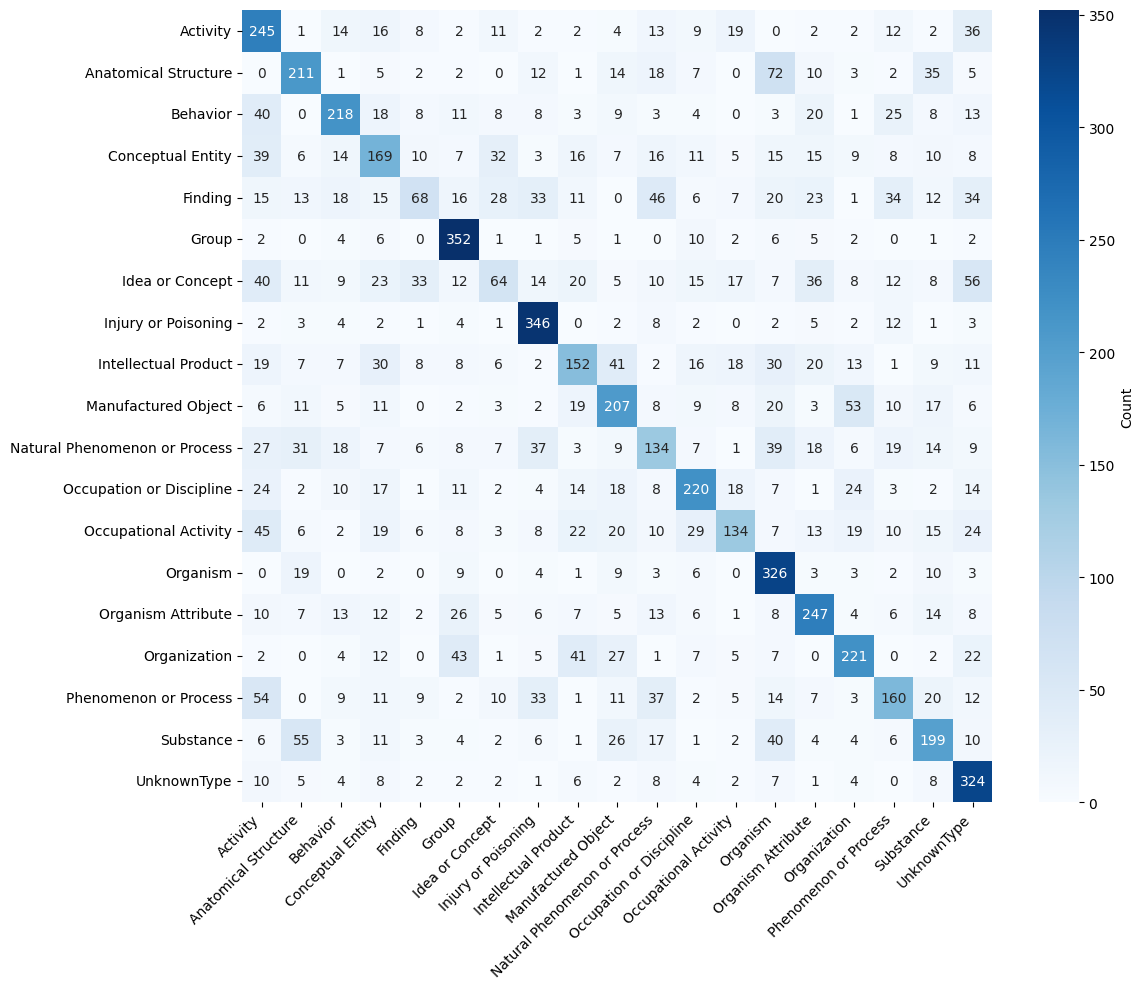

In [ ]:
# Y = []
# for key in test_set_type_id_list_of_samples.keys():
#     Y.extend([int(key)]*len(test_set_type_id_list_of_samples[key]))
# Y = np.array(Y)
# y_preds = np.array(y_preds)

# confusion_matrix = confusion_matrix(Y, y_preds)

# plt.figure(figsize=(12, 10))
# sns.heatmap(
#     confusion_matrix,
#     annot=True,
#     fmt='d',
#     cmap='Blues',
#     xticklabels=type_ids,
#     yticklabels=type_ids,
#     cbar_kws={'label': 'Count'}
# )

# plt.xticks(rotation=45, ha='right')
# plt.yticks(rotation=0)

# plt.tight_layout()
# plt.savefig(f'{dir}/projection_umap_confusion_matrix.pdf', dpi=300, bbox_inches='tight', format='pdf')

# plt.show()

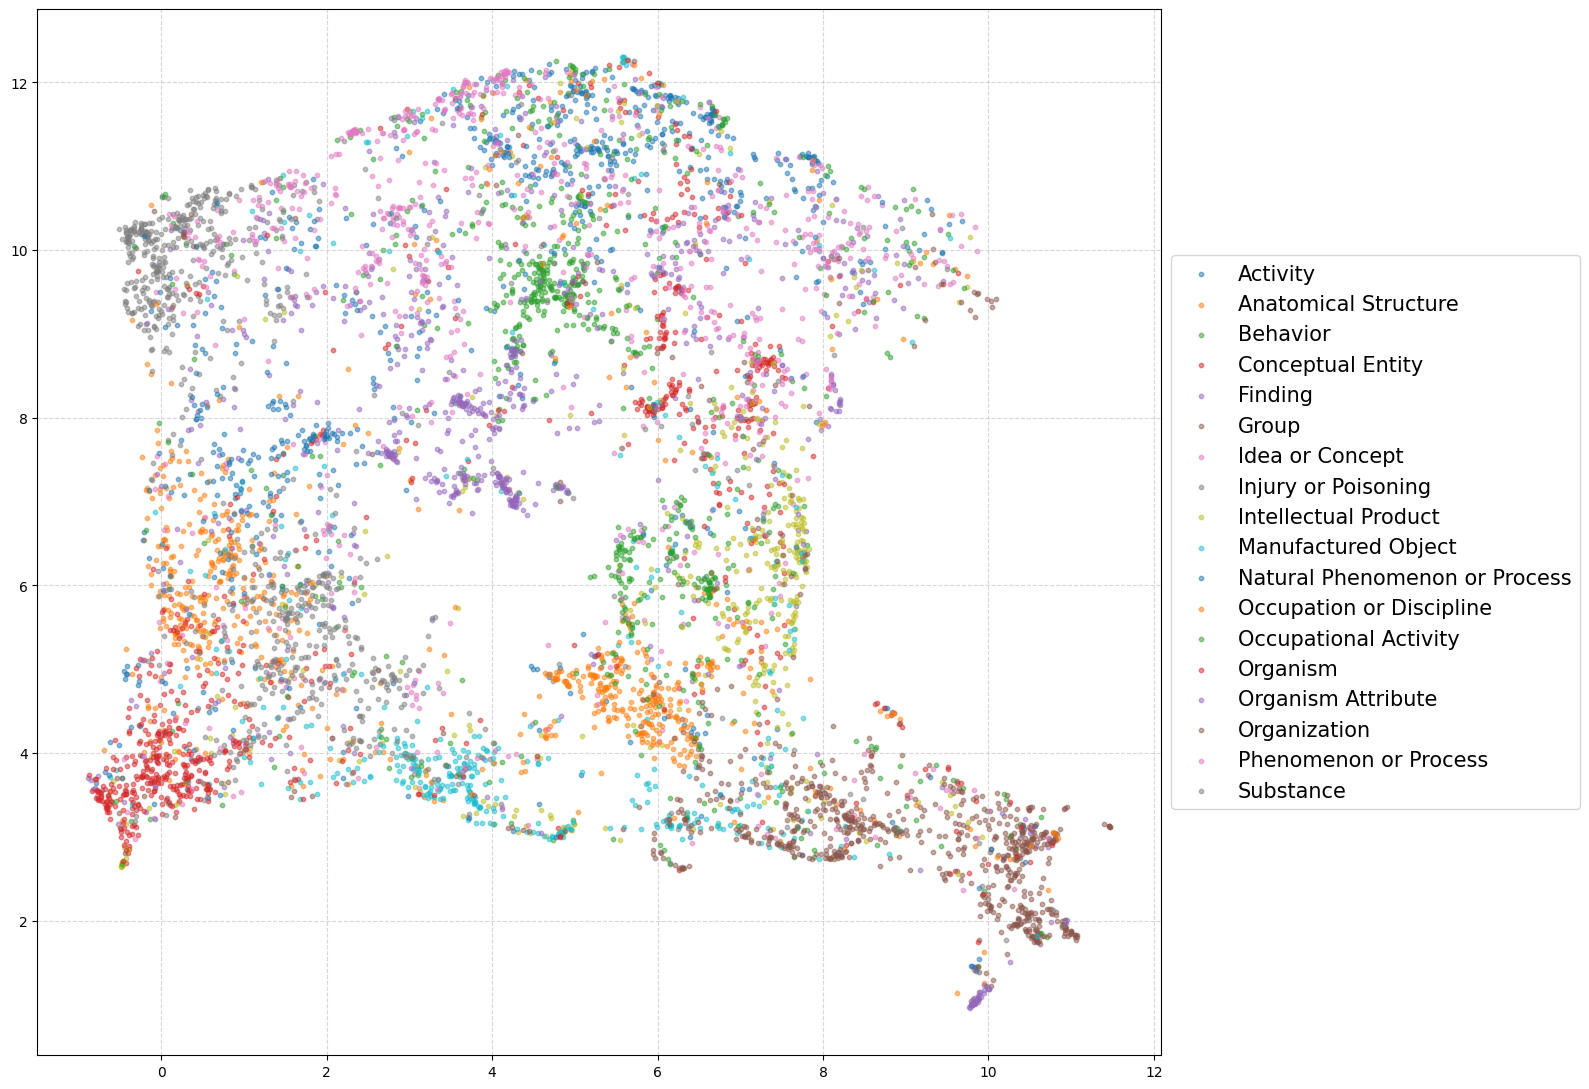

In [ ]:
# Y = []
# for key in test_set_type_id_list_of_samples.keys():
#     Y.extend([int(key)]*len(test_set_type_id_list_of_samples[key]))
# Y = np.array(Y)

# plt.figure(figsize=(16, 11))
# for i in range(len(type_ids)):
#     if i == unknown_index:
#         continue
#     mask = Y == i
#     plt.scatter(
#         embedding[mask, 0],
#         embedding[mask, 1],
#         s=10,
#         alpha=0.5,
#         label=type_ids[i]
#     )
# plt.legend(
#     bbox_to_anchor=(1, 0.5),
#     loc='center left',
#     fontsize=15,
#     ncol=1,
#     frameon=True,
# )
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.savefig(f'{dir}/projection_umap.pdf', dpi=300, bbox_inches='tight', format='pdf')

# plt.show()

In [ ]:
from google.colab import runtime

runtime.unassign()